## Access ANMN CTD Mooring NRT data in Parquet

A jupyter notebook to show how to access and plot ANMN Mooring NRT data available as a [Parquet](https://parquet.apache.org) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/7b901002-b1dc-46c3-89f2-b4951cedca48).

ðŸ“Œ The point of truth for this notebook is [on GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/mooring_ctd_delayed_qc.ipynb).

In [1]:
dataset_name = "mooring_ctd_delayed_qc"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 240 packages in 63ms


âœ… Local version 0.2.1 is up to date (remote: 0.2.1)


In [3]:
from DataQuery import GetAodn

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [4]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 132 ms, sys: 30.2 ms, total: 162 ms
Wall time: 6.95 s


In [5]:
aodn_dataset.dataset.partitioning.schema

site_code: string
timestamp: int32
polygon: string

## List unique partition values

In [6]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('site_code')
print(list(unique_partition_value)[0:10])  # showing a subset only

['GBRHIS', 'NWSROW', 'SAM7DS', 'SAM5CB', 'ITFMHB', 'SAM1DS', 'SAMUSG', 'SYD140', 'KIM400', 'CAM100']
CPU times: user 25.5 ms, sys: 10.7 ms, total: 36.1 ms
Wall time: 25.2 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


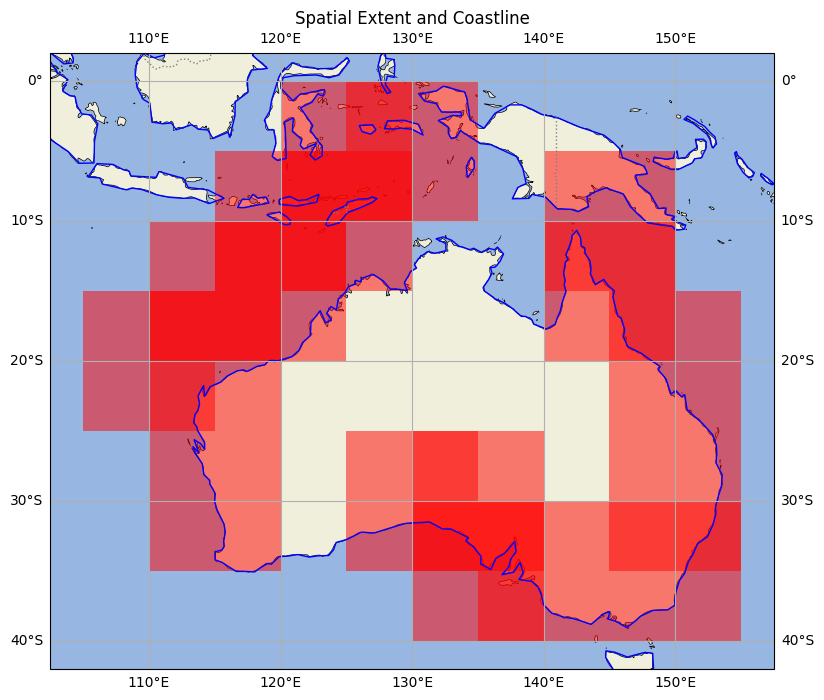

In [7]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset
Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset.

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [8]:
aodn_dataset.get_temporal_extent()

(Timestamp('2008-05-04 23:00:00.999997952'),
 Timestamp('2024-07-15 06:30:00.999997952'))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [9]:
metadata = aodn_dataset.get_metadata()
metadata

2025-06-05 13:09:56,880 - aodn.GetAodn - INFO - Retrieving metadata for aodn-cloud-optimised/mooring_ctd_delayed_qc.parquet
2025-06-05 13:09:56,996 - aodn.GetAodn - WARNING - Old 'dataset_medata' deprecated key found in parquet schema. Renamed to 'global_attributes'. Dataset should be updated


{'TIME': {'type': 'timestamp[ns]',
  'axis': 'T',
  'comment': 'timeOffsetPP: TIME values and time_coverage_start/end global attributes have been applied the following offset : -10 hours.',
  'long_name': 'time',
  'standard_name': 'time',
  'valid_max': 90000.0,
  'valid_min': 0.0},
 'TIMESERIES': {'type': 'int32',
  'cf_role': 'timeseries_id',
  'long_name': 'unique_identifier_for_each_timeseries_feature_instance_in_this_file'},
 'LATITUDE': {'type': 'double',
  'axis': 'Y',
  'long_name': 'latitude',
  'reference_datum': 'WGS84 geographic coordinate system',
  'standard_name': 'latitude',
  'units': 'degrees_north',
  'valid_max': 90.0,
  'valid_min': -90.0},
 'LONGITUDE': {'type': 'double',
  'axis': 'X',
  'long_name': 'longitude',
  'reference_datum': 'WGS84 geographic coordinate system',
  'standard_name': 'longitude',
  'units': 'degrees_east',
  'valid_max': 180.0,
  'valid_min': -180.0},
 'NOMINAL_DEPTH': {'type': 'float',
  'axis': 'Z',
  'long_name': 'nominal depth',
  'pos

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [10]:
%%time
df = aodn_dataset.get_data(date_start='2022-12-05', date_end='2022-12-15', lat_min=-34, lat_max=-28, lon_min=151, lon_max=160)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23040 entries, 0 to 23039
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   TIME                      23040 non-null  datetime64[ns]
 1   TIMESERIES                23040 non-null  int32         
 2   LATITUDE                  23040 non-null  float64       
 3   LONGITUDE                 23040 non-null  float64       
 4   NOMINAL_DEPTH             23040 non-null  float32       
 5   CNDC                      23040 non-null  float32       
 6   CNDC_quality_control      23040 non-null  float32       
 7   TEMP                      23040 non-null  float32       
 8   TEMP_quality_control      23040 non-null  float32       
 9   PSAL                      23040 non-null  float32       
 10  PSAL_quality_control      23040 non-null  float32       
 11  PRES_REL                  23040 non-null  float32       
 12  PRES_REL_quality_c

In [ ]:
# Download subsetted data as CSV
df.aodn.download_as_csv()

## Create a TIME and scalar/number filter

In [11]:
%%time
df = aodn_dataset.get_data(date_start='2022-12-05', date_end='2022-12-15', lat_min=-34, lat_max=-28, lon_min=151, lon_max=160, scalar_filter={'site_code': 'CH100'})
df.info()
df['site_code'] = df['site_code'].astype('category')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   TIME                      5760 non-null   datetime64[ns]
 1   TIMESERIES                5760 non-null   int32         
 2   LATITUDE                  5760 non-null   float64       
 3   LONGITUDE                 5760 non-null   float64       
 4   NOMINAL_DEPTH             5760 non-null   float32       
 5   CNDC                      5760 non-null   float32       
 6   CNDC_quality_control      5760 non-null   float32       
 7   TEMP                      5760 non-null   float32       
 8   TEMP_quality_control      5760 non-null   float32       
 9   PSAL                      5760 non-null   float32       
 10  PSAL_quality_control      5760 non-null   float32       
 11  PRES_REL                  5760 non-null   float32       
 12  PRES_REL_quality_con

In [12]:
df[df['NOMINAL_DEPTH'] == 9]['site_code'].unique()

['CH100']
Categories (1, object): ['CH100']

<Axes: title={'center': 'Temperature for each location'}, xlabel='sea_water_temperature', ylabel='sea_water_practical_salinity'>

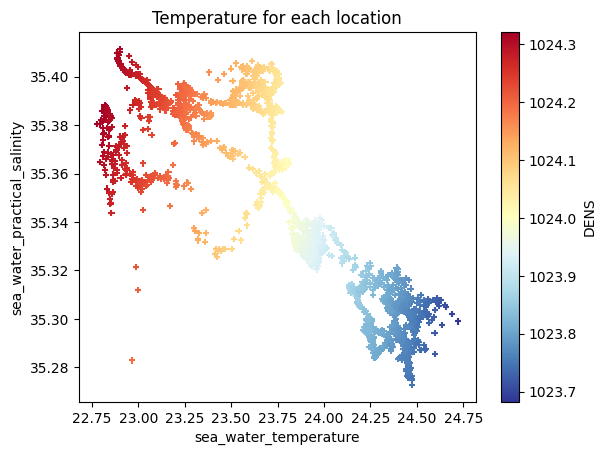

In [13]:
df[(df['NOMINAL_DEPTH'] == 9) & (df['site_code']=='CH100')].plot.scatter(x='TEMP', y='PSAL', 
                                                                         c='DENS', marker='+', linestyle="None", cmap='RdYlBu_r', 
                                                                         title='Temperature for each location',
                                                                         ylabel=metadata['PSAL']['standard_name'],
                                                                         xlabel=metadata['TEMP']['standard_name'])

<Axes: xlabel='TIME', ylabel='sea_water_temperature'>

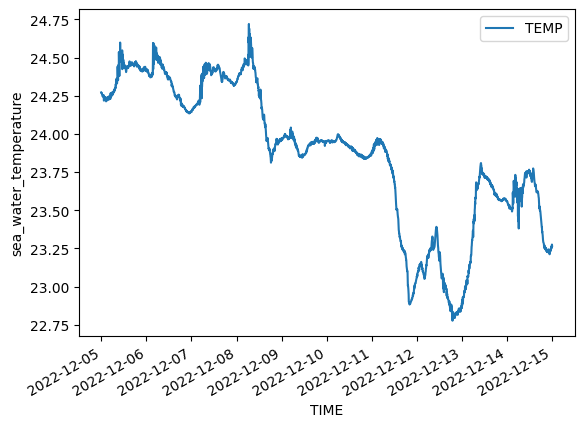

In [14]:
df[(df['NOMINAL_DEPTH'] == 9) & (df['site_code']=='CH100')].sort_values('TIME').plot(y='TEMP', x='TIME',
                                                                                     ylabel=metadata['TEMP']['standard_name'])

## Plot TS diagram - compare with quality control values

### Example A

<Axes: title={'center': 'Temperature for each location'}, xlabel='sea_water_temperature', ylabel='sea_water_practical_salinity'>

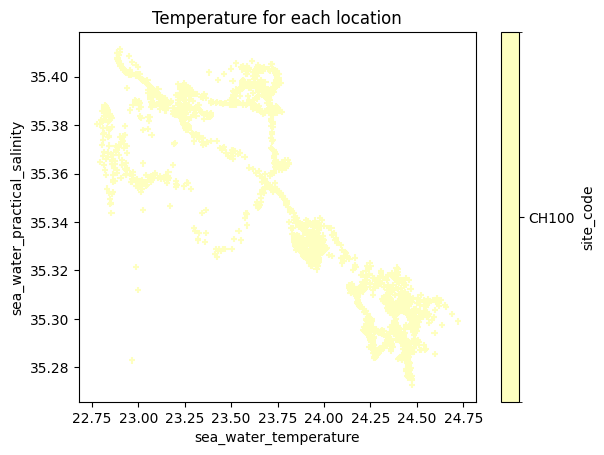

In [15]:
df[(df['NOMINAL_DEPTH'] <= 20) ].plot.scatter(x='TEMP', y='PSAL', c='site_code', 
                                              marker='+', linestyle="None", cmap='RdYlBu_r', 
                                              title='Temperature for each location',
                                              ylabel=metadata['PSAL']['standard_name'],
                                              xlabel=metadata['TEMP']['standard_name'])

<Axes: title={'center': 'Temperature for each location'}, xlabel='sea_water_temperature', ylabel='sea_water_practical_salinity'>

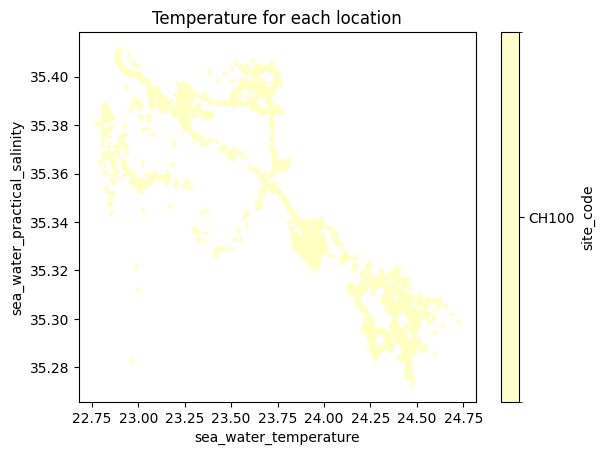

In [16]:
df[(df['NOMINAL_DEPTH'] <= 20) & (df['PSAL_quality_control'] == 1) ].plot.scatter(x='TEMP', y='PSAL', c='site_code', 
                                                                                  marker='+', linestyle="None", cmap='RdYlBu_r', 
                                                                                  alpha=0.8, title='Temperature for each location',
                                                                                  ylabel=metadata['PSAL']['standard_name'],
                                                                                  xlabel=metadata['TEMP']['standard_name'])

## Example B

<Axes: title={'center': 'TS at CH100 at various nominal depths'}, xlabel='sea_water_temperature', ylabel='sea_water_practical_salinity'>

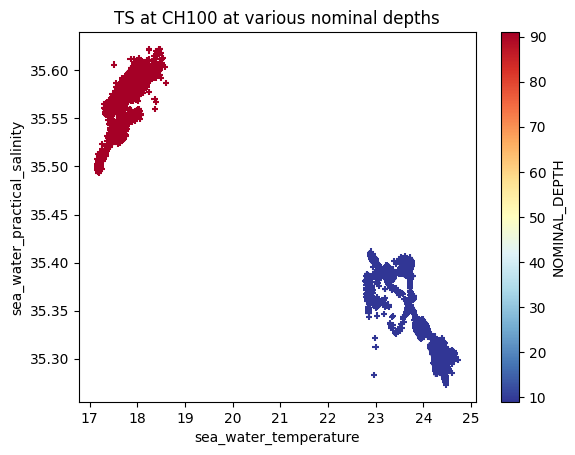

In [17]:
df[(df['site_code']=='CH100')].plot.scatter(x='TEMP', y='PSAL', c='NOMINAL_DEPTH', 
                                            marker='+', linestyle="None", cmap='RdYlBu_r', 
                                            title='TS at CH100 at various nominal depths',
                                              ylabel=metadata['PSAL']['standard_name'],
                                              xlabel=metadata['TEMP']['standard_name'])

<Axes: title={'center': 'TS at CH100 at various nominal depths'}, xlabel='sea_water_temperature', ylabel='sea_water_practical_salinity'>

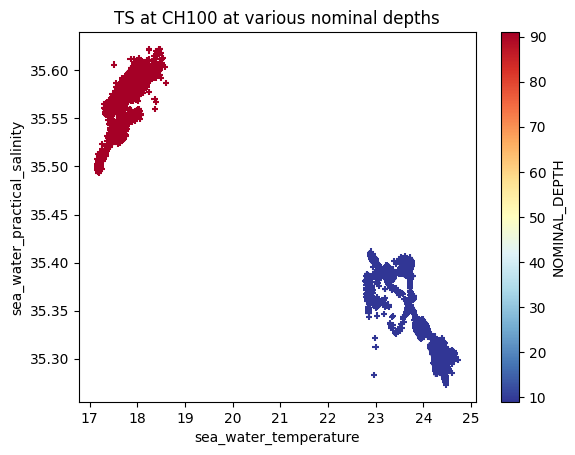

In [18]:
df[(df['site_code']=='CH100') & (df['PSAL_quality_control'] == 1)].plot.scatter(x='TEMP', y='PSAL', 
                                                                                c='NOMINAL_DEPTH', marker='+', linestyle="None", 
                                                                                cmap='RdYlBu_r', 
                                                                                title='TS at CH100 at various nominal depths',
                                                                                ylabel=metadata['PSAL']['standard_name'],
                                                                                xlabel=metadata['TEMP']['standard_name'])